In [ ]:
!pip install -q transformers pandas openpyxl


import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("openGPT-X/Teuken-7B-instruct-research-v0.4")

model = AutoModelForSequenceClassification.from_pretrained(
    "MB55/teuken7b-advance-classifier",
    device_map="auto",            
    torch_dtype=torch.float16    
)

model.eval()

 
ood_df = pd.read_excel("outofdomain_eval_data.xlsx")

print(ood_df.head())

 
def batch_predict(texts, batch_size=4):   
    all_predictions = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        if "token_type_ids" in inputs:
            del inputs["token_type_ids"]

      
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        batch_preds = logits.argmax(dim=-1).tolist()

        all_predictions.extend(batch_preds)

    return all_predictions

 
texts = ood_df["input_text"].tolist()
predictions = batch_predict(texts, batch_size=4)   

 
ood_df["prediction"] = predictions

 
label_map = {0: "NON-ADVANCE", 1: "ADVANCE"}
ood_df["prediction_label"] = ood_df["prediction"].map(label_map)

 
ood_df.to_excel("/content/outofdomain_predictions.xlsx", index=False)

 
from google.colab import files
files.download("/content/outofdomain_predictions.xlsx")


The repository for openGPT-X/Teuken-7B-instruct-research-v0.4 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/openGPT-X/Teuken-7B-instruct-research-v0.4.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at openGPT-X/Teuken-7B-instruct-research-v0.4 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

                                          input_text end_label
0    Wer kann Meinung erklären, S3. Versuch mal. […]   advance
1                                      Du bist dran.   advance
2  Bitte was? Was hat S3 denn gesagt, wiederholst...   advance
3          Du WEISST nicht mehr, was du gesagt hast?   advance
4                             S2. Was hat S3 getört?   advance


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

 
ood_predictions = pd.read_excel("outofdomain_predictions.xlsx")

 
print(ood_predictions.head())


                                          input_text end_label  prediction  \
0    Wer kann Meinung erklären, S3. Versuch mal. […]   advance           1   
1                                      Du bist dran.   advance           1   
2  Bitte was? Was hat S3 denn gesagt, wiederholst...   advance           0   
3          Du WEISST nicht mehr, was du gesagt hast?   advance           1   
4                             S2. Was hat S3 getört?   advance           1   

  prediction_label  
0          ADVANCE  
1          ADVANCE  
2      NON-ADVANCE  
3          ADVANCE  
4          ADVANCE  


In [ ]:
 
ood_predictions["prediction_label"].value_counts()


,count
prediction_label,
ADVANCE,558
NON-ADVANCE,222


In [ ]:
import pandas as pd

 
df = pd.read_excel("outofdomain_predictions.xlsx")

print(df.columns.tolist())


['input_text', 'end_label', 'prediction', 'prediction_label']


In [ ]:
 
df["end_label"] = df["end_label"].astype(str).str.strip().str.upper()
df["prediction_label"] = df["prediction_label"].astype(str).str.strip().str.upper()


In [ ]:
label_map = {"NON-ADVANCE": 0, "ADVANCE": 1}

df["true_label_int"] = df["end_label"].map(label_map)
df["predicted_label_int"] = df["prediction"]  


In [34]:
df = df.dropna(subset=["true_label_int", "predicted_label_int"])


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = df["true_label_int"]
y_pred = df["predicted_label_int"]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")


In [ ]:
Accuracy:  0.8949
Precision: 1.0000
Recall:    0.8949
F1 Score:  0.9445

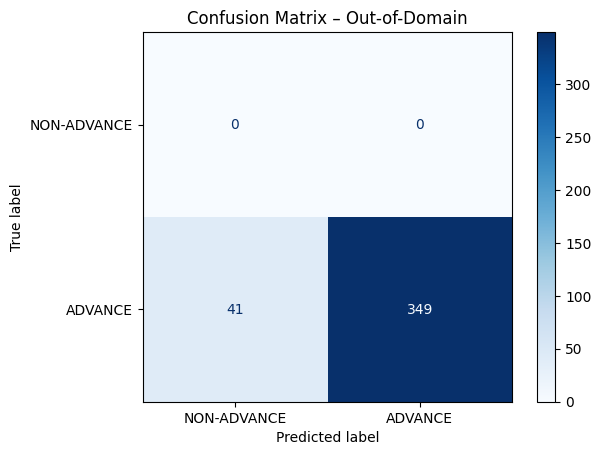

In [36]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NON-ADVANCE", "ADVANCE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Out-of-Domain")
plt.grid(False)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

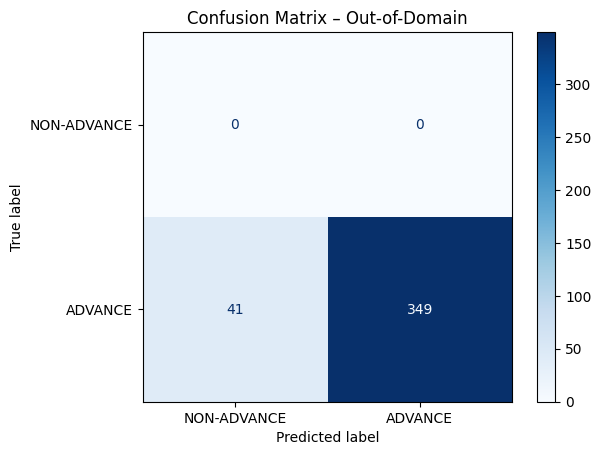

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NON-ADVANCE", "ADVANCE"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Out-of-Domain")
plt.grid(False)


plt.savefig("/content/confusion_matrix_ood.png", dpi=300, bbox_inches='tight')


from google.colab import files
files.download("/content/confusion_matrix_ood.png")


In [ ]:
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [accuracy, precision, recall, f1]
}

import pandas as pd
results_df = pd.DataFrame(metrics)
results_df.to_csv("/content/out_of_domain_metrics.csv", index=False)


from google.colab import files
files.download("/content/out_of_domain_metrics.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

with open("/content/out_of_domain_report.txt", "w") as f:
    f.write(f"Accuracy:  {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall:    {recall:.4f}\n")
    f.write(f"F1 Score:  {f1:.4f}\n")


files.download("/content/out_of_domain_report.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>